本notebook收集与[《交通时空大数据分析、挖掘与可视化（Python版）》](https://book.douban.com/subject/36092545/)

In [1]:
#让Python不显示warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

# 数据预处理

## 读取数据

In [2]:
#读取GPS数据
BUS_GPS= pd.read_csv(r'data/busgps.csv',header = None)
BUS_GPS.columns = ['GPSDateTime', 'LineId', 'LineName', 'NextLevel', 'PrevLevel',
       'Strlatlon', 'ToDir', 'VehicleId', 'VehicleNo', 'unknow']
BUS_GPS.head(5)

,GPSDateTime,LineId,LineName,NextLevel,PrevLevel,Strlatlon,ToDir,VehicleId,VehicleNo,unknow
0,2019-01-16 23:59:59,7100,71,2,1,"121.335413,31.173188",1,沪D-R7103,Z5A-0021,1
1,2019-01-17 00:00:00,7100,71,2,1,"121.334616,31.172271",1,沪D-R1273,Z5A-0002,1
2,2019-01-17 00:00:00,7100,71,24,23,"121.339955,31.173025",0,沪D-R5257,Z5A-0020,1
3,2019-01-17 00:00:01,7100,71,14,13,"121.409491,31.20433",0,沪D-R5192,Z5A-0013,1
4,2019-01-17 00:00:03,7100,71,15,14,"121.398615,31.200253",0,沪D-T0951,Z5A-0022,1


In [3]:
#时间转换为datetime格式
BUS_GPS['GPSDateTime'] = pd.to_datetime(BUS_GPS['GPSDateTime'])


<AxesSubplot:>

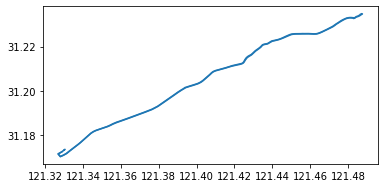

In [4]:
#读取公交线数据
shp = r'data/busline.json'
line = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
line.plot()

<AxesSubplot:>

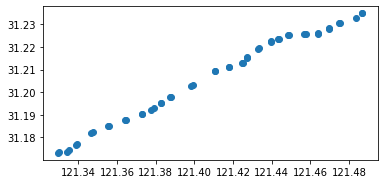

In [5]:
#读取公交站点数据
shp = r'data/busstop.json'
stop = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
stop.plot()

## 坐标转换

In [6]:
#切分经纬度的字符串
BUS_GPS['lon'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[0])
BUS_GPS['lat'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[1])
#坐标系转换
BUS_GPS['lon'],BUS_GPS['lat'] = tbd.gcj02towgs84(BUS_GPS['lon'].astype(float),BUS_GPS['lat'].astype(float))

## 采样间隔

In [7]:
#一辆车在一个时刻只保留一条记录
BUS_GPS_clean = BUS_GPS.drop_duplicates(subset = ['VehicleId','GPSDateTime'])

In [8]:
#采样间隔的统计
BUS_GPS_clean = BUS_GPS_clean.sort_values(by = ['VehicleId','GPSDateTime'])
#将数据复制一份，避免计算采样间隔时影响到数据
BUS_GPS_tmp = BUS_GPS_clean.copy()
#将下一条数据上移一行
BUS_GPS_tmp['VehicleId1'] = BUS_GPS_tmp['VehicleId'].shift(-1)
BUS_GPS_tmp['GPSDateTime1'] = BUS_GPS_tmp['GPSDateTime'].shift(-1)
#计算时间差，即采样间隔
BUS_GPS_tmp['duration'] = (BUS_GPS_tmp['GPSDateTime1']-BUS_GPS_tmp['GPSDateTime']).dt.total_seconds()
#仅保留同一辆车的记录
BUS_GPS_tmp = BUS_GPS_tmp[BUS_GPS_tmp['VehicleId1']==BUS_GPS_tmp['VehicleId']]
#采样间隔
BUS_GPS_tmp[['duration']]

,duration
3283,20.0
3304,15.0
3315,15.0
3326,15.0
3336,30.0
...,...
123391,15.0
123411,19.0
123450,15.0
123472,15.0


In [9]:
#使用tbd.sample_duration方法，输入车辆ID与时间所在列，同样可计算数据采样间隔
sample_duration = tbd.sample_duration(BUS_GPS_clean,col=['VehicleId', 'GPSDateTime'])

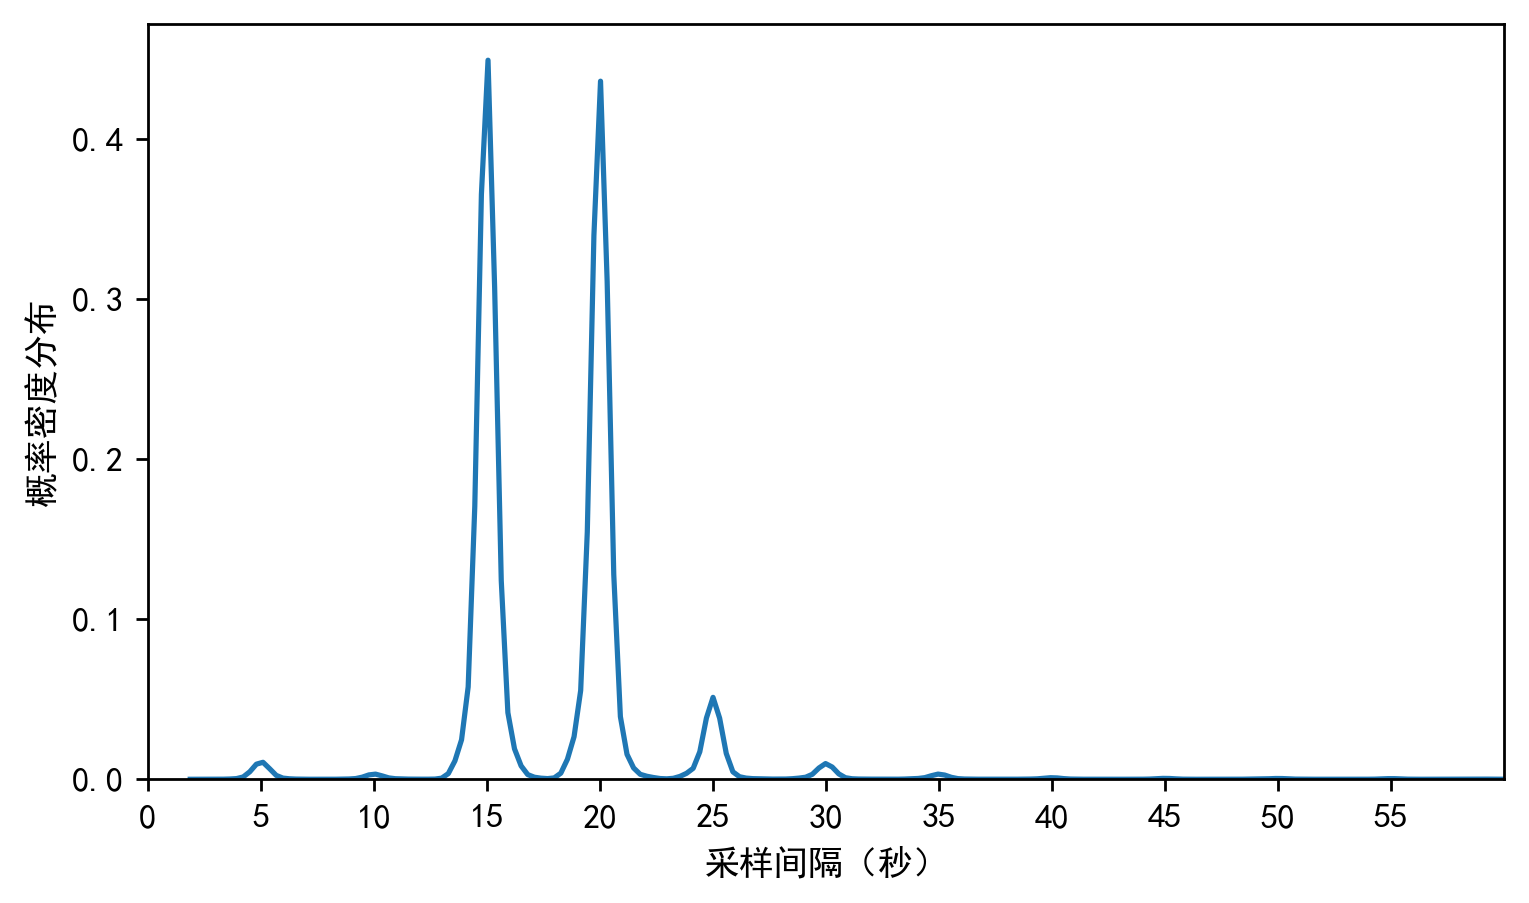

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
fig     = plt.figure(1,(7,4),dpi = 250)    
ax1      = plt.subplot(111)
#采样间隔的核密度分布
sns.kdeplot(sample_duration[sample_duration['duration']<60]['duration'])
plt.xlim(0,60)
plt.xticks(range(0,60,5),range(0,60,5))
plt.xlabel('采样间隔（秒）')
plt.ylabel('概率密度分布')
plt.show()

In [11]:
#使用tbd.data_summary可以输出数据概况
tbd.data_summary(BUS_GPS_clean,col=['VehicleId', 'GPSDateTime'],show_sample_duration=True)

Amount of data
-----------------
Total number of data items:  125386
Total number of individuals:  41
Data volume of individuals(Mean):  3058.1951
Data volume of individuals(Upper quartile):  3554.0
Data volume of individuals(Median):  3186.0
Data volume of individuals(Lower quartile):  2748.0

Data time period
-----------------
Start time:  2019-01-16 23:59:59
End time:  2019-01-17 23:59:48

Sampling interval
-----------------
Mean:  20.7615 s
Upper quartile:  20.0 s
Median:  19.0 s
Lower quartile:  15.0 s


## 地图匹配

In [12]:
len(BUS_GPS_clean)

125386

In [13]:
#删除信息与前后数据相同的数据以减少数据量
#某个体连续n条数据除了时间以外其他信息都相同，则只保留首末两条数据
BUS_GPS_clean = tbd.clean_same(BUS_GPS_clean,col=['VehicleId', 'GPSDateTime', 'lon','lat'])
len(BUS_GPS_clean)

66362

<AxesSubplot:>

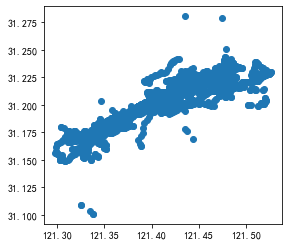

In [14]:
# 将数据转换为GeoDataFrame，以便进行地图匹配
BUS_GPS_clean['geometry'] = gpd.points_from_xy(BUS_GPS_clean['lon'],BUS_GPS_clean['lat'])
BUS_GPS_clean = gpd.GeoDataFrame(BUS_GPS_clean)
#转换坐标系为投影坐标系，方便后面计算距离
BUS_GPS_clean.crs = {'init':'epsg:4326'}
BUS_GPS_clean_2416 = BUS_GPS_clean.to_crs(epsg = 2416)
BUS_GPS_clean.plot()

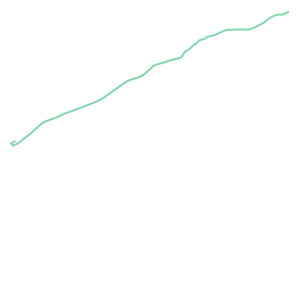

In [15]:
#转换坐标系为投影坐标系，方便后面计算距离
line.crs = {'init':'epsg:4326'}
line_2416 = line.to_crs(epsg = 2416)
#公交线路数据里面的geometry
lineshp = line_2416['geometry'].iloc[0]
linename = line_2416['name'].iloc[0]
lineshp

In [16]:
#利用project方法，将数据点投影至公交线路上
BUS_GPS_clean_2416['project'] = BUS_GPS_clean_2416['geometry'].apply(lambda r:lineshp.project(r))
#原始的坐标点存储在一个字段中
BUS_GPS_clean_2416['geometry_orgin'] = BUS_GPS_clean_2416['geometry']
#利用interpolate方法，生成匹配的坐标点
BUS_GPS_clean_2416['geometry'] = BUS_GPS_clean_2416['project'].apply(lambda r:lineshp.interpolate(r))
#计算原始点和匹配点之间的距离
BUS_GPS_clean_2416['diff'] = BUS_GPS_clean_2416.apply(lambda r:r['geometry_orgin'].distance(r['geometry']),axis = 1)
BUS_GPS_clean_2416.iloc[:2].T


,74598,3283
GPSDateTime,2019-01-17 15:28:02,2019-01-17 05:29:42
LineId,7100,7100
LineName,71,71
NextLevel,255,2
PrevLevel,65535,1
Strlatlon,"121.440188,31.278699","121.334823,31.173047"
ToDir,85,1
VehicleId,沪D-98307,沪D-R0725
VehicleNo,S2S-0280,Z5A-0026
unknow,1,1


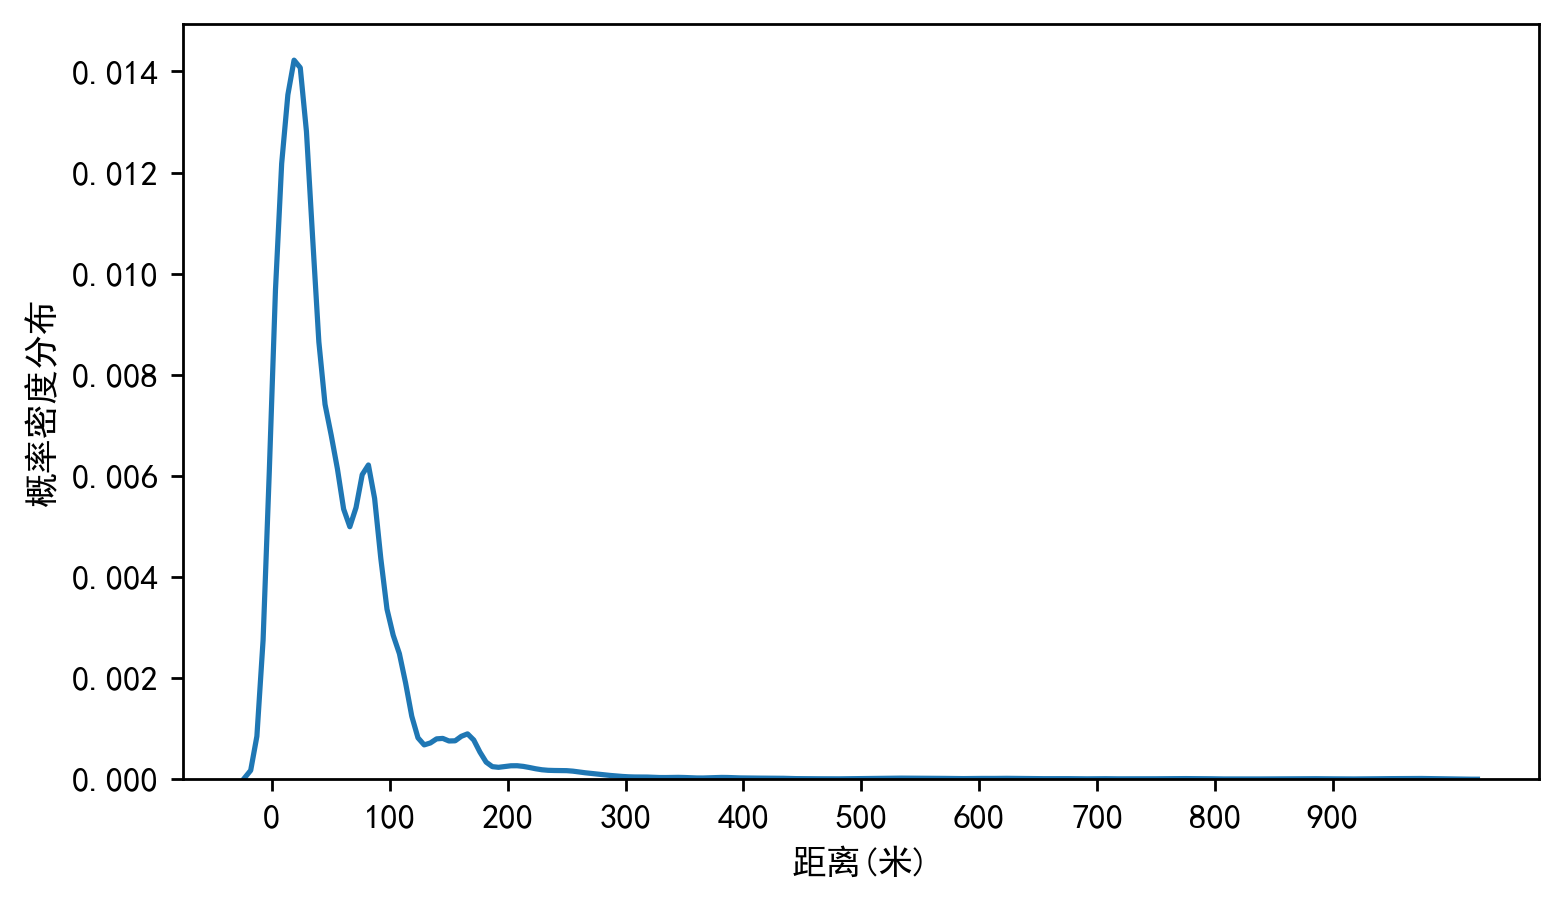

In [17]:
#绘制距离分布的核密度分布
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
fig     = plt.figure(1,(7,4),dpi = 250)    
ax1      = plt.subplot(111)
#核密度分布
sns.kdeplot(BUS_GPS_clean_2416[BUS_GPS_clean_2416['diff']<1000]['diff'])
plt.xticks(range(0,1000,100),range(0,1000,100))
plt.ylabel('概率密度分布')
plt.xlabel('距离(米)')
plt.show()

<AxesSubplot:>

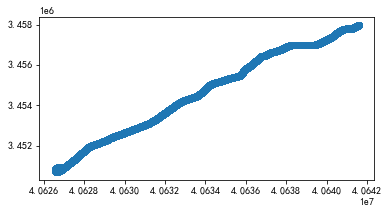

In [18]:
#只筛选保留距离公交线路200米内的坐标点
BUS_GPS_clean_2416 = BUS_GPS_clean_2416[BUS_GPS_clean_2416['diff']<200]
#地图匹配后的匹配点
BUS_GPS_clean_2416.plot()

<AxesSubplot:>

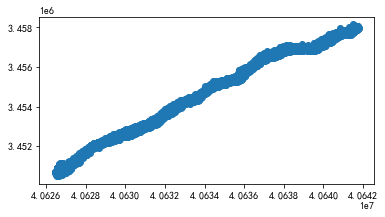

In [19]:
#地图匹配后的原始点
tmp = BUS_GPS_clean_2416[['geometry_orgin']]
tmp.columns = ['geometry']
gpd.GeoDataFrame(tmp).plot()

## 利用tbd包筛选距离公交线一定范围外的数据

<AxesSubplot:>

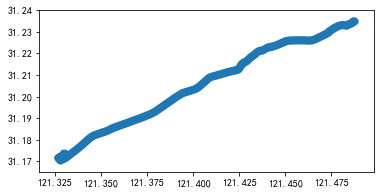

In [20]:
#对公交线做缓冲区
line.crs = {'init':'epsg:4326'}
line_buffer = line.to_crs(epsg = 2416)
line_buffer['geometry'] = line_buffer.buffer(200)
line_buffer = line_buffer.to_crs(epsg = 4326)
line_buffer.plot()

<AxesSubplot:>

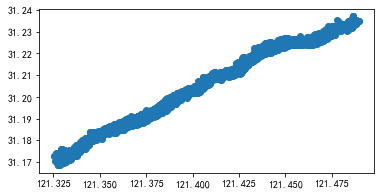

In [21]:
#tbd.clean_outofshape方法剔除公交线路缓冲区范围外的数据
#其原理是先栅格化后对应，会有一定误差，可通过accuracy参数控制栅格大小
BUS_GPS_clean_2 = tbd.clean_outofshape(BUS_GPS_clean,line_buffer,col = ['lon','lat'],accuracy = 100)
BUS_GPS_clean_2.plot()

# 车辆运行图

In [22]:
BUS_GPS = BUS_GPS_clean_2416.copy()

In [23]:
#获取车辆ID表，放进list
VehicleId = list(BUS_GPS['VehicleId'].drop_duplicates())

In [24]:
#选取第一辆车的数据
tmp = BUS_GPS[BUS_GPS['VehicleId'] == VehicleId[0]]

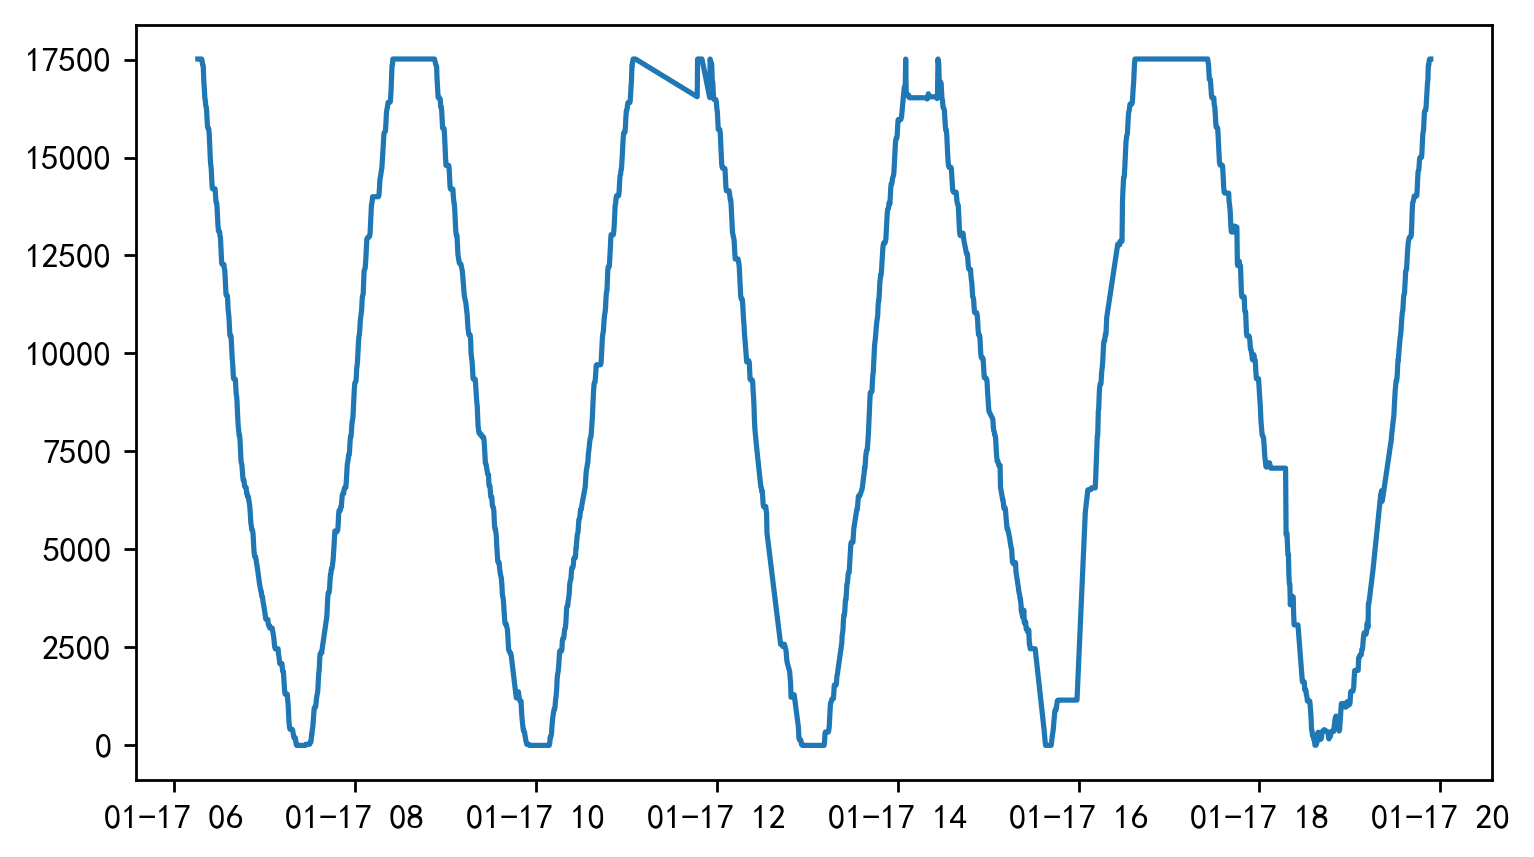

In [25]:
#绘制第一辆车的运行图
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(7,4),dpi = 250)    
ax1      = plt.subplot(111)
#绘制运行图
plt.plot(tmp['GPSDateTime'],tmp['project'])
plt.show()

In [26]:
#标记站点位置
import geopandas as gpd
#读取公交站点数据
shp = r'data/busstop.json'
stop = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
#转换坐标
stop.crs = {'init':'epsg:4326'}
stop = stop.to_crs(epsg = 2416)
#地图匹配
stop['project'] = stop['geometry'].apply(lambda r:lineshp.project(r))
stop = stop[stop['linename'] == linename]
stop

,linename,stopname,lat,lon,geometry,project
0,71路(延安东路外滩-申昆路枢纽站),延安东路外滩,31.232760,121.483252,POINT (40641596.952 3458003.743),0.000000
1,71路(延安东路外滩-申昆路枢纽站),西藏中路,31.228843,121.471204,POINT (40640440.524 3457538.236),1281.080261
2,71路(延安东路外滩-申昆路枢纽站),黄陂北路,31.226289,121.466207,POINT (40640037.316 3457270.104),1768.983693
3,71路(延安东路外滩-申昆路枢纽站),成都北路,31.224169,121.460679,POINT (40639509.755 3457022.725),2352.613247
4,71路(延安东路外滩-申昆路枢纽站),茂名北路,31.224245,121.453549,POINT (40638802.002 3456998.598),3063.642630
5,71路(延安东路外滩-申昆路枢纽站),上海展览中心,31.223671,121.445507,POINT (40638010.148 3456902.242),3869.162441
6,71路(延安东路外滩-申昆路枢纽站),常德路,31.221882,121.440474,POINT (40637528.345 3456691.831),4395.548556
7,71路(延安东路外滩-申昆路枢纽站),华山路,31.221176,121.436915,POINT (40637182.303 3456601.864),4753.958500
8,71路(延安东路外滩-申昆路枢纽站),镇宁路,31.218242,121.430528,POINT (40636577.340 3456265.283),5462.531742
9,71路(延安东路外滩-申昆路枢纽站),江苏路,31.214177,121.424154,POINT (40635984.535 3455810.149),6213.357033


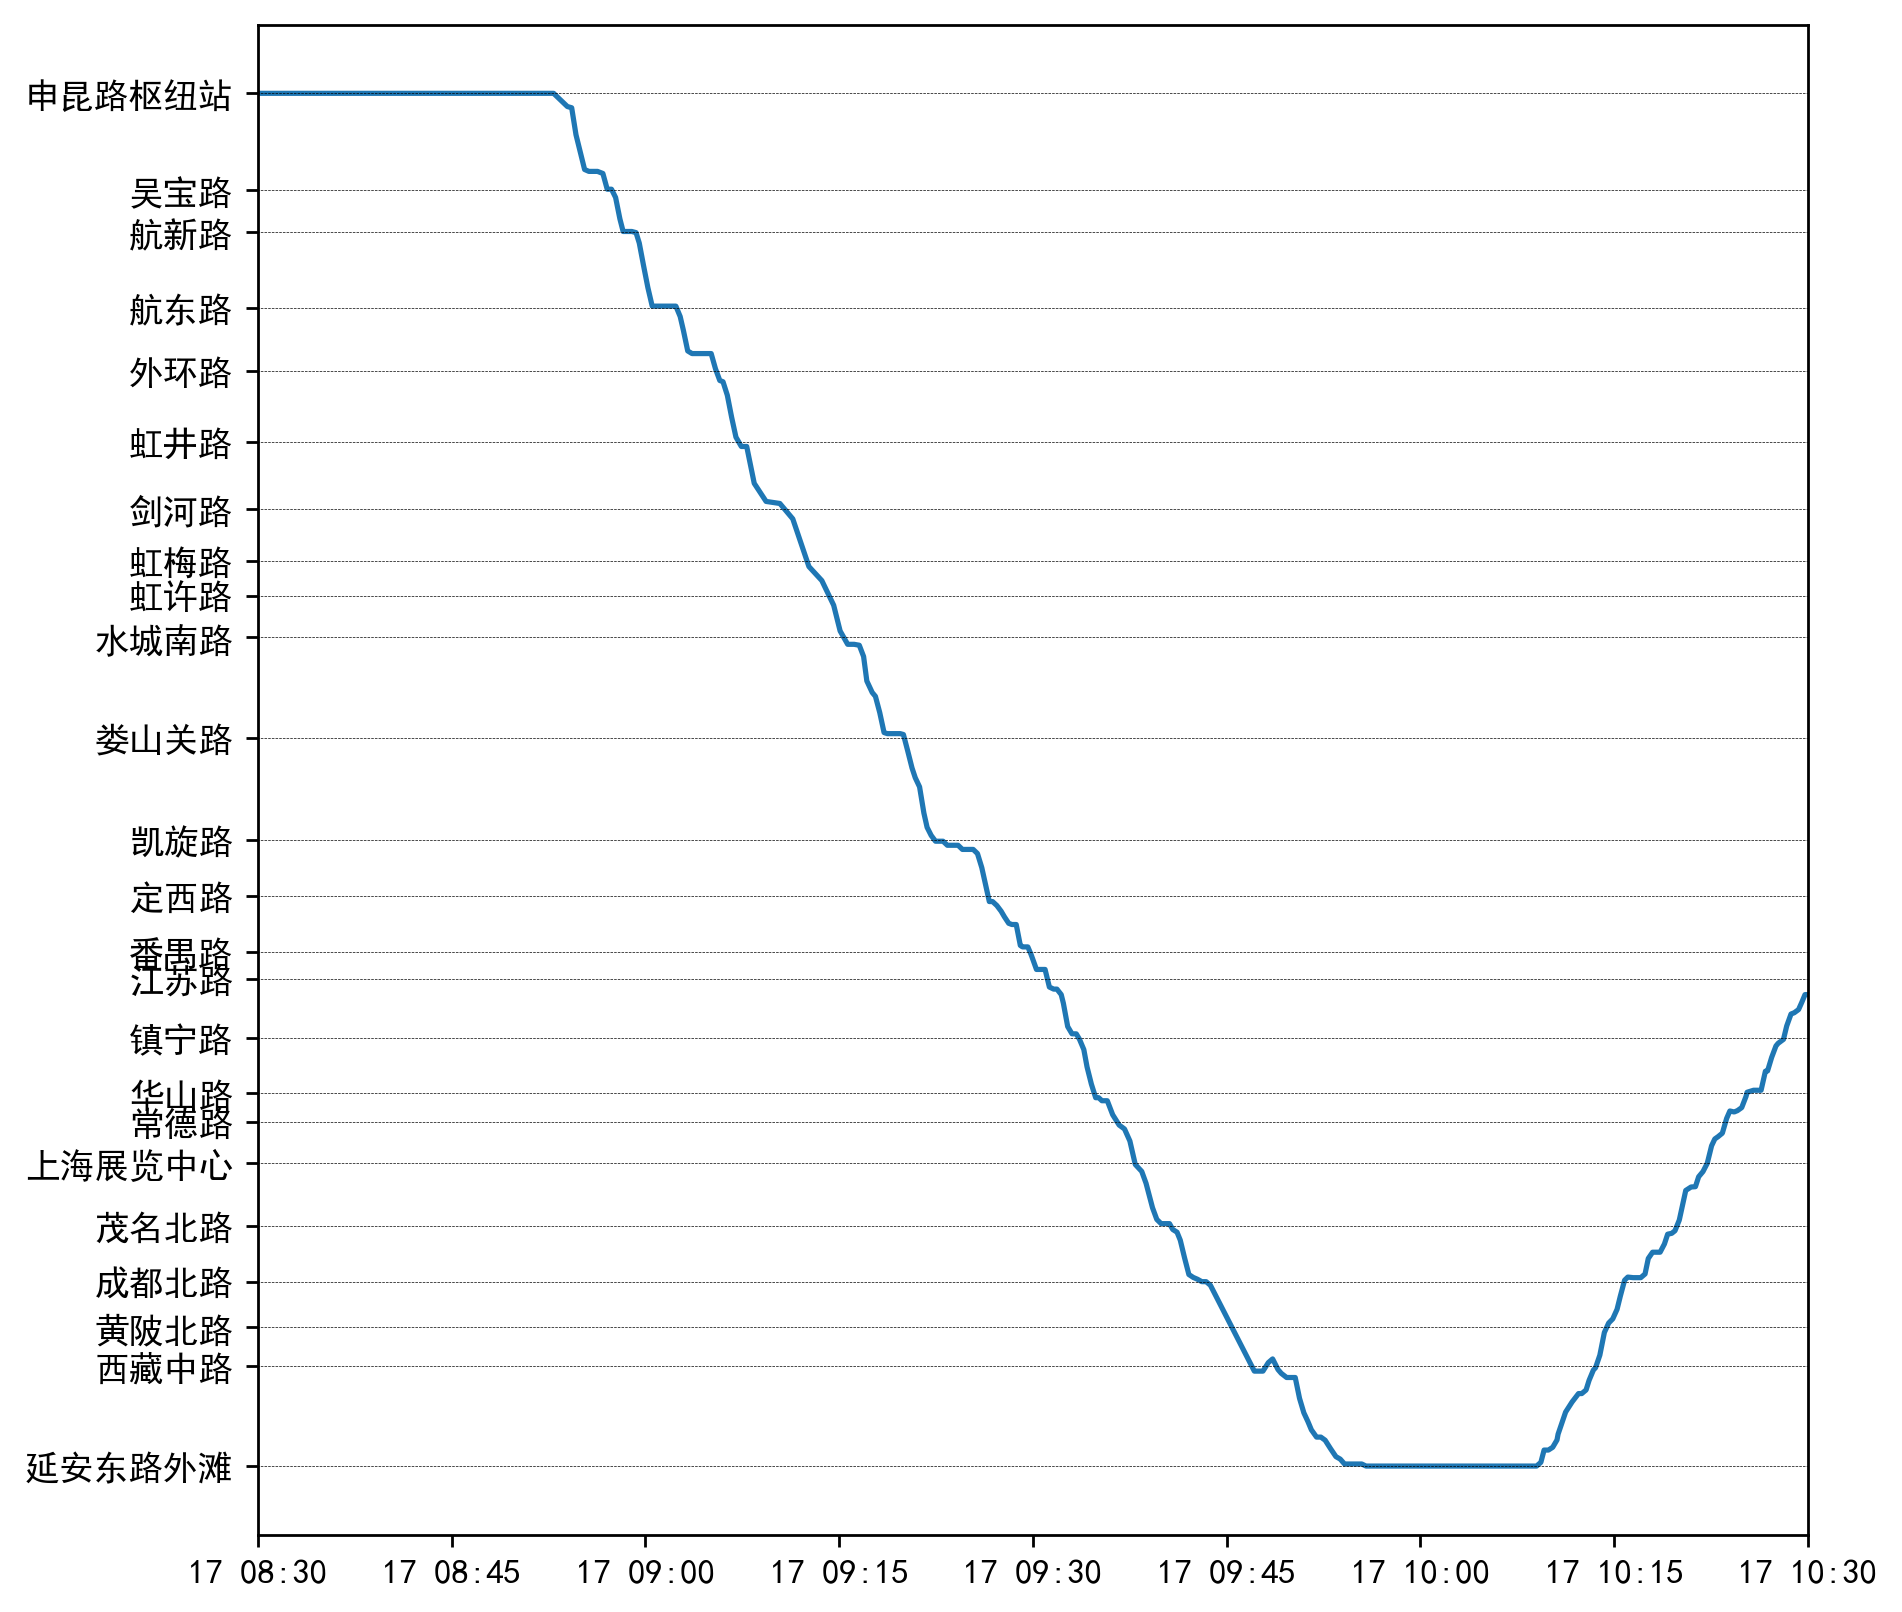

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(8,8),dpi = 250)    
ax1      = plt.subplot(111)
#绘制运行图
plt.plot(tmp['GPSDateTime'],tmp['project'])
#灰色线标注站点位置
for i in range(len(stop)):
    project = stop['project'].iloc[i]
    stopname = stop['stopname'].iloc[i]
    plt.plot([pd.to_datetime('2019-01-17 00:00:00'),
              pd.to_datetime('2019-01-18 00:00:00')],
             [project,project],'k--',lw=0.2)
#标记站点名字
plt.yticks(stop['project'],stop['stopname'])
#设定时间范围
plt.xlim(pd.to_datetime('2019-01-17 08:30:00'),
        pd.to_datetime('2019-01-17 10:30:00'))
plt.show()

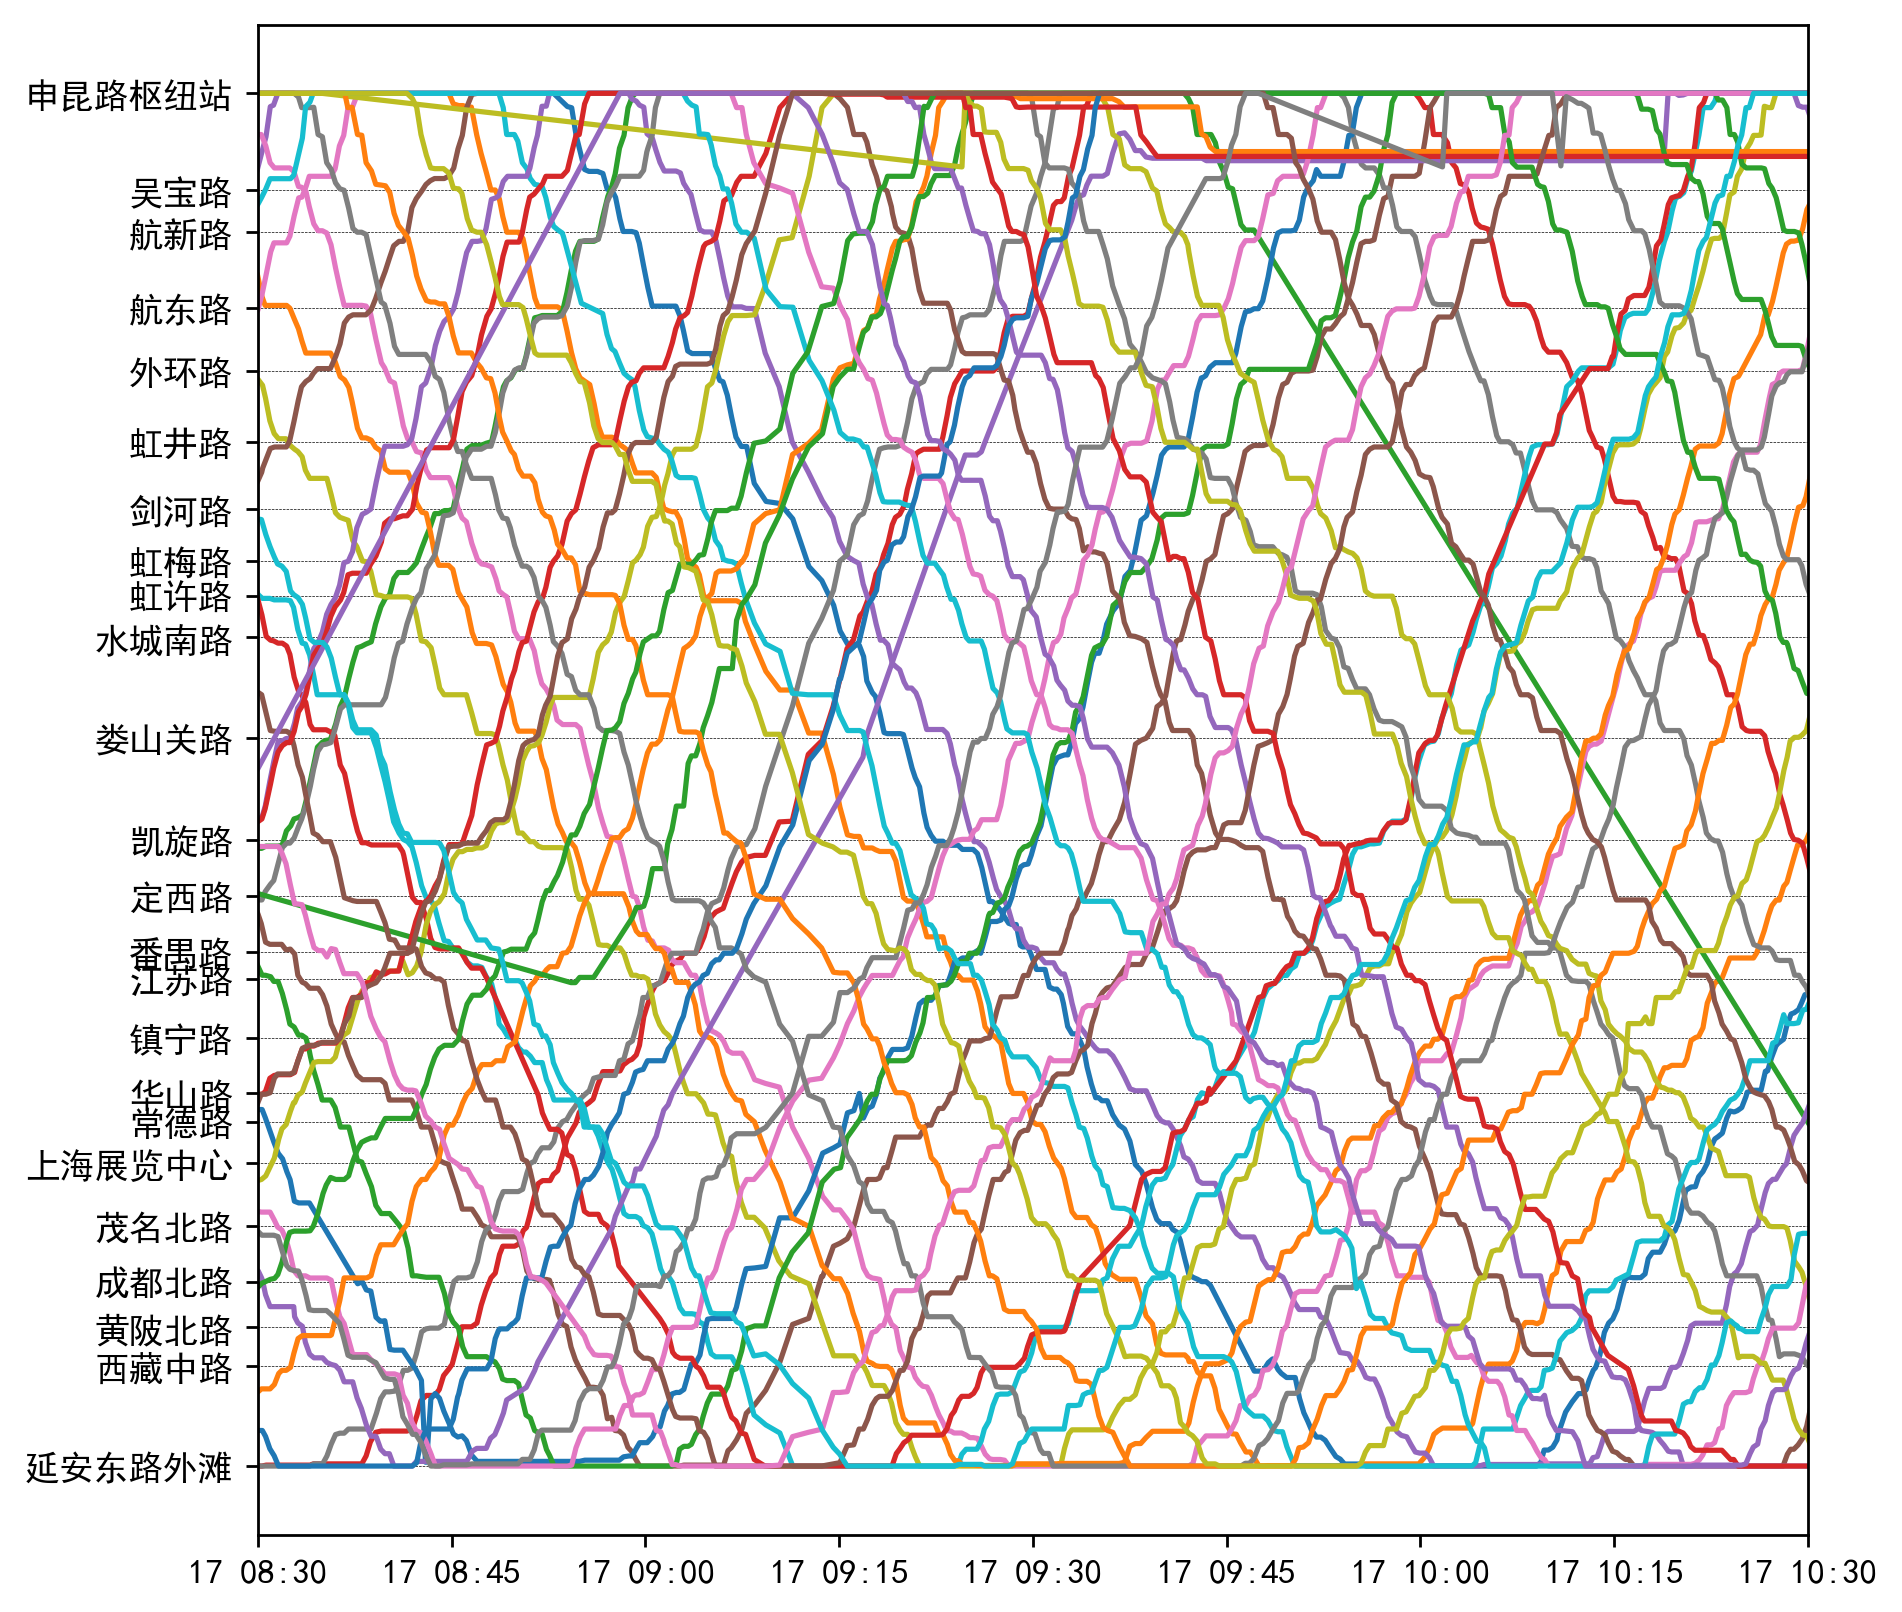

In [28]:
#绘制所有车的运行图
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(8,8),dpi = 250)    
ax1      = plt.subplot(111)

for i in range(len(stop)):
    project = stop['project'].iloc[i]
    stopname = stop['stopname'].iloc[i]
    plt.plot([pd.to_datetime('2019-01-17 00:00:00'),
              pd.to_datetime('2019-01-18 00:00:00')],
             [project,project],'k--',lw=0.2)

#每辆车绘制一条运行图的曲线
for Vehicle in BUS_GPS['VehicleId'].drop_duplicates():
    tmp = BUS_GPS[BUS_GPS['VehicleId'] == Vehicle]
    plt.plot(tmp['GPSDateTime'],tmp['project'])

#标记站点名字
plt.yticks(stop['project'],stop['stopname'])
#设定时间范围
plt.xlim(pd.to_datetime('2019-01-17 08:30:00'),
        pd.to_datetime('2019-01-17 10:30:00'))
plt.show()

In [29]:
#对车辆重新编号
BUS_GPS['GPSDateTime1'] = BUS_GPS['GPSDateTime'].shift()
BUS_GPS['VehicleId1'] = BUS_GPS['VehicleId'].shift()

#如果时间间隔大于30分钟，则认为是新的车
duration = 30*60
#此时两个条件：时间间隔大于30分钟或者本来这一条记录就是新车
BUS_GPS['flag'] = ((BUS_GPS['VehicleId1']!=BUS_GPS['VehicleId'])|
                   ((BUS_GPS['GPSDateTime']-BUS_GPS['GPSDateTime1']).dt.total_seconds()>duration)).astype(int)
#重新编号
BUS_GPS['VehicleId_new'] = BUS_GPS['flag'].cumsum()

In [30]:
BUS_GPS_reindex = tbd.id_reindex(BUS_GPS,'VehicleId',timegap = 1800,timecol = 'GPSDateTime')

In [31]:
len(BUS_GPS['VehicleId'].drop_duplicates())

40

In [32]:
len(BUS_GPS_reindex['VehicleId_new'].drop_duplicates())

140

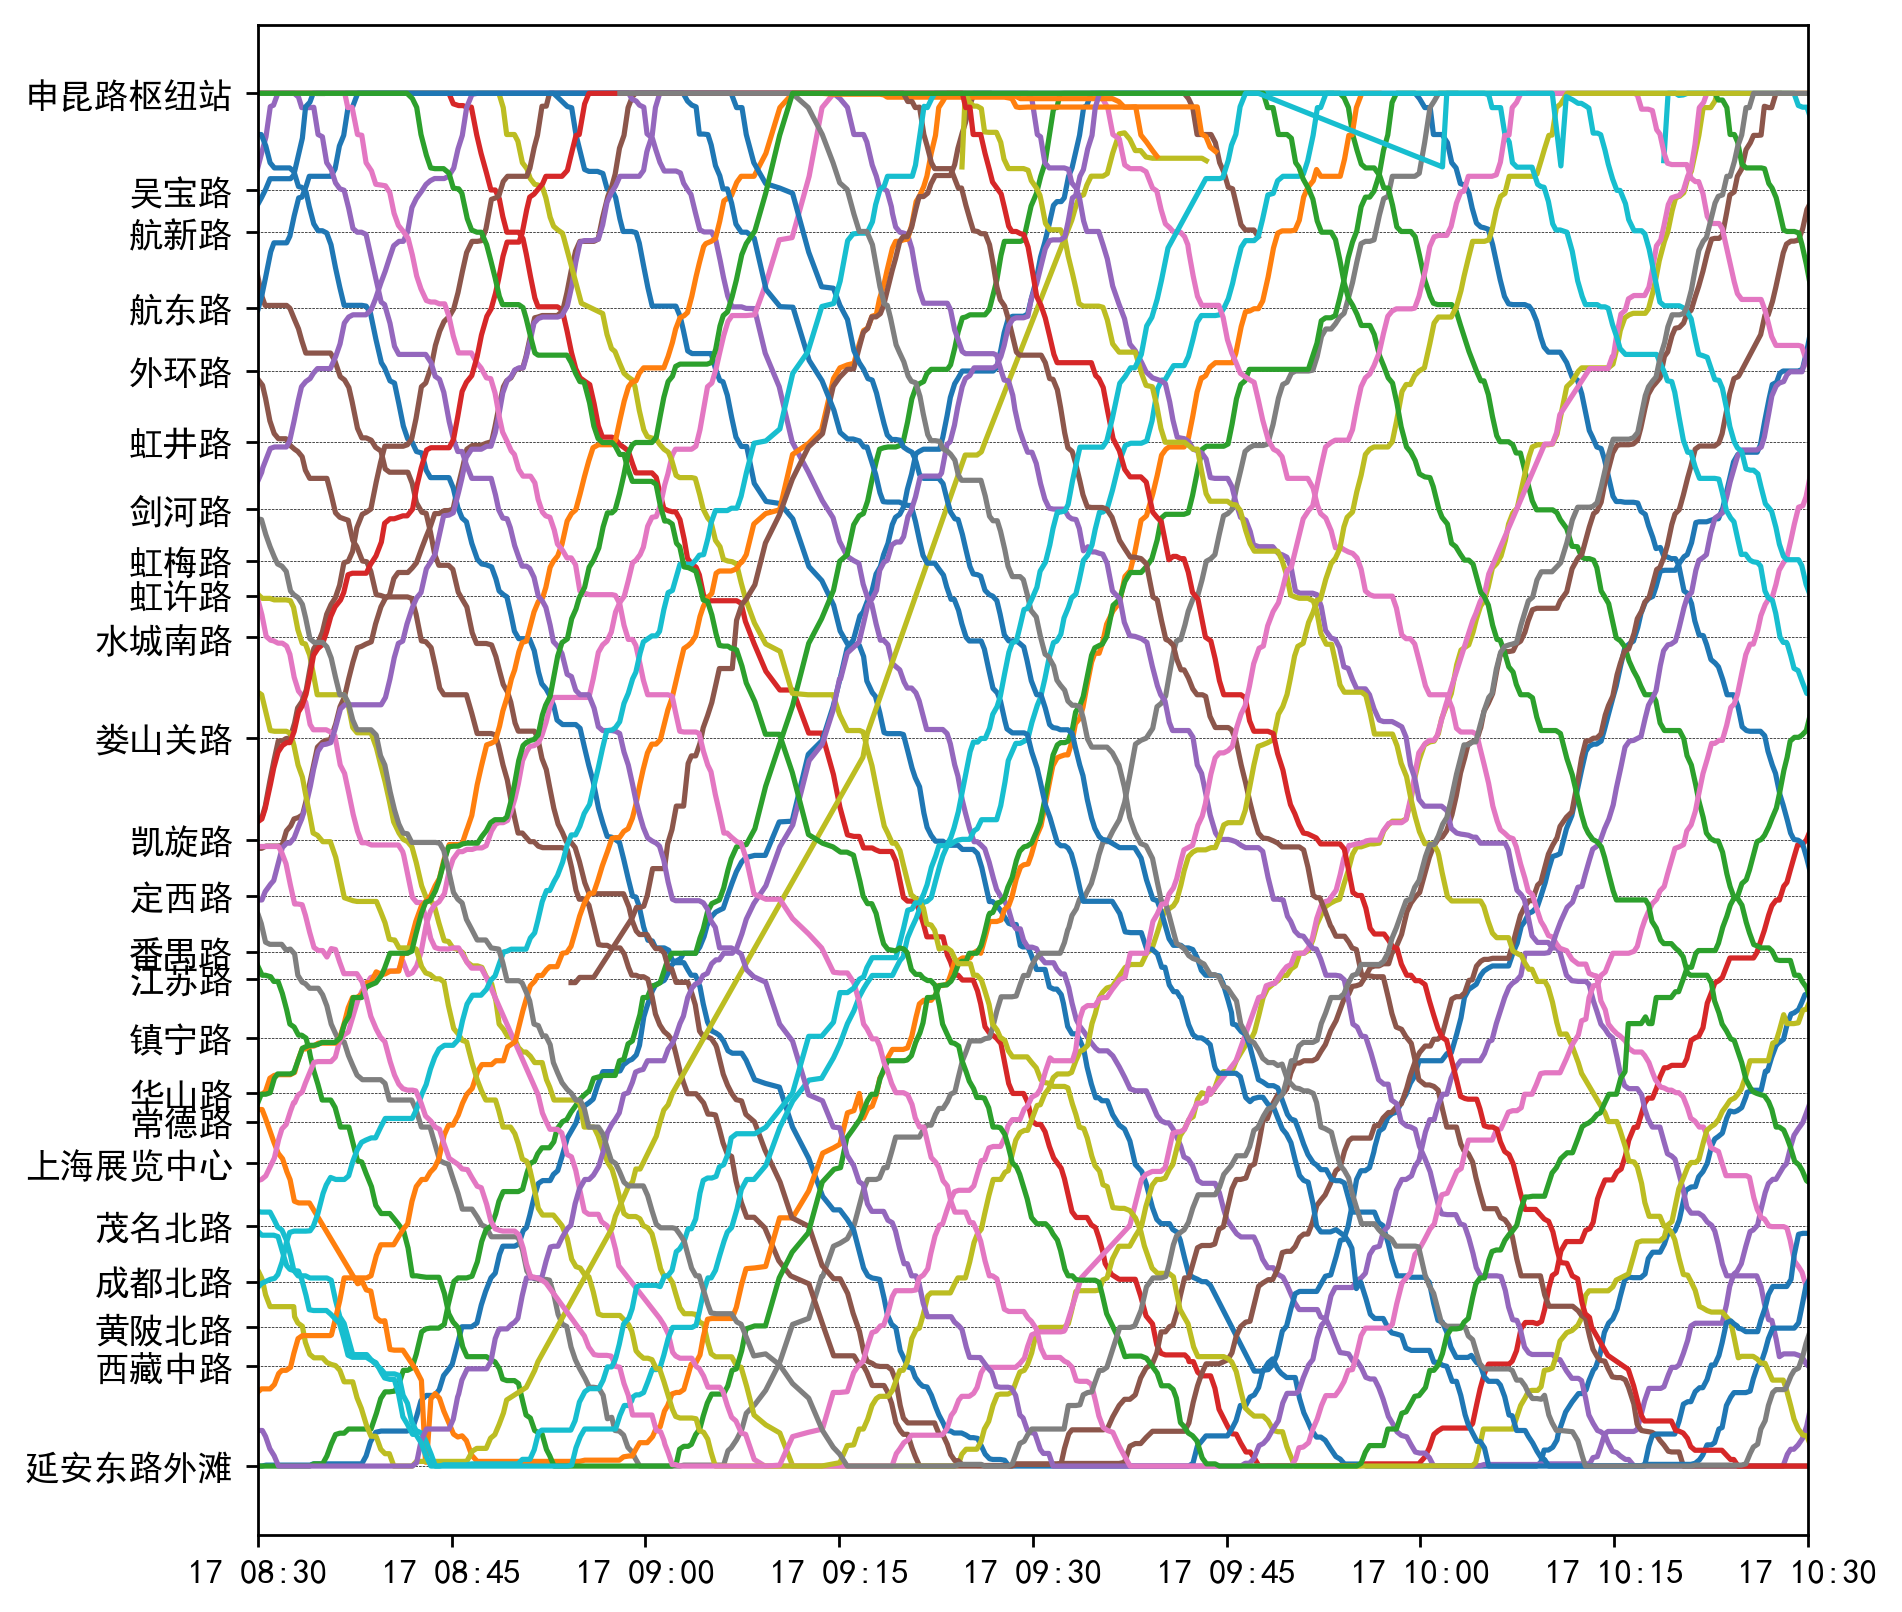

In [33]:
#绘制所有车的运行图
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(8,8),dpi = 250)    
ax1      = plt.subplot(111)
#标注站点所在位置的横线
for i in range(len(stop)):
    project = stop['project'].iloc[i]
    stopname = stop['stopname'].iloc[i]
    plt.plot([pd.to_datetime('2019-01-17 00:00:00'),
              pd.to_datetime('2019-01-18 00:00:00')],
             [project,project],'k--',lw=0.2)
#每辆车绘制一条运行图的曲线
for Vehicle in BUS_GPS_reindex['VehicleId_new'].drop_duplicates():
    tmp = BUS_GPS_reindex[BUS_GPS_reindex['VehicleId_new'] == Vehicle]
    plt.plot(tmp['GPSDateTime'],tmp['project'])
#标记站点名字
plt.yticks(stop['project'],stop['stopname'])
#设定时间范围
plt.xlim(pd.to_datetime('2019-01-17 08:30:00'),
        pd.to_datetime('2019-01-17 10:30:00'))
plt.show()

In [34]:
BUS_GPS = tbd.id_reindex(BUS_GPS,'VehicleId',timegap = 1800,timecol = 'GPSDateTime',suffix = '')

# 到离站识别

## 数据整理

In [35]:
#将时间转换为距离观测时段开始时间经过了多少秒
BUS_GPS['time_st'] = (BUS_GPS['GPSDateTime']-pd.to_datetime('2019-01-17 00:00:00')).dt.total_seconds()
#保留部分列
BUS_project = BUS_GPS[['VehicleId','time_st','project']]
BUS_project

,VehicleId,time_st,project
0,0,22558.0,17512.985950
1,0,22573.0,17512.985950
2,0,22708.0,17512.985950
3,0,22728.0,17460.926648
4,0,22744.0,17372.771452
...,...,...,...
63997,138,69895.0,17330.830394
63998,138,69920.0,17377.850876
63999,138,69935.0,17512.985950
64000,138,69955.0,17512.985950


## 对一辆车的一个站点识别到站

In [36]:
#选取某一辆车
car = 1
tmp = BUS_project[BUS_project['VehicleId']==car]

In [37]:
#选取某一个站点
stopname = '申昆路枢纽站'
position = stop[stop['stopname'] == stopname]['project'].iloc[0]
position

17512.98594955427

In [38]:
#对站点周边做100米缓冲区
stopbuffer = 100
#生成一个buffer的polygon
from shapely.geometry import LineString
buffer_polygon = LineString([[0,position],
                             [24*3600,position]]).buffer(stopbuffer)
#生成车辆轨迹的linestring
bus_linestring = LineString(tmp[['time_st','project']].values)
#提取车辆轨迹与buffer的交集
line_intersection = bus_linestring.intersection(buffer_polygon)

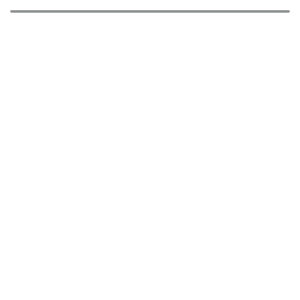

In [39]:
#站点周边100米缓冲区
buffer_polygon

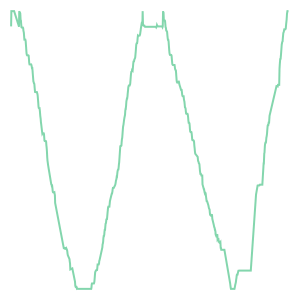

In [40]:
#车辆运行图
bus_linestring

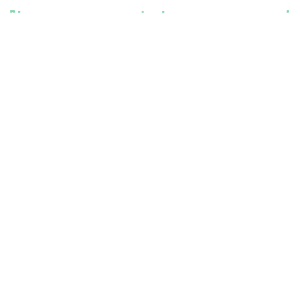

In [41]:
#通过线与面的交集，识别到离站信息
line_intersection

In [42]:
#从中提取其中的到离站轨迹
import shapely
if line_intersection.is_empty:
    pass
else:
    #将每一次到站信息放入list中
    if type(line_intersection) == shapely.geometry.linestring.LineString:
        arrive = [line_intersection]
    else:
        arrive = list(line_intersection)
#构建为DataFrame
arrive = pd.DataFrame(arrive)
#取每一次到离站时间
arrive['arrivetime']= arrive[0].apply(lambda r:r.coords[0][0])
arrive['leavetime']= arrive[0].apply(lambda r:r.coords[-1][0])
arrive

,0,arrivetime,leavetime
0,LINESTRING (42441.44185528011 17412.9859495542...,42441.441855,42648.356886
1,LINESTRING (42939.47782107216 17412.9859495542...,42939.477821,42970.877278
2,LINESTRING (50719.82289707468 17412.9859495542...,50719.822897,50724.395159
3,LINESTRING (52005.92046799509 17412.9859495542...,52005.920468,52033.181903
4,LINESTRING (59832.42927475676 17412.9859495542...,59832.429275,59918.000000


In [43]:
#定义时间阈值
mintime = 5*60
#通过时间阈值筛选到离站信息
a = arrive[['arrivetime']]
a.columns = ['time']
a['flag'] = 1
b = arrive[['leavetime']]
b.columns = ['time']
b['flag'] = 0
c = pd.concat([a,b]).sort_values(by = 'time')
c['time1'] = c['time'].shift(-1)
c['flag_1'] = ((c['time1']-c['time'])<mintime)&(c['flag']==0)
c['flag_2'] = c['flag_1'].shift().fillna(False)
c['flag_3'] = c['flag_1']|c['flag_2']
c = c[-c['flag_3']]
arrive_new = c[c['flag'] == 1][['time']]
arrive_new.columns = ['arrivetime']
arrive_new['leavetime'] = list(c[c['flag'] == 0]['time'])
arrive_new['stopname'] = stopname
arrive_new['VehicleId'] = car
arrive_new

,arrivetime,leavetime,stopname,VehicleId
0,42441.441855,42970.877278,申昆路枢纽站,1
2,50719.822897,50724.395159,申昆路枢纽站,1
3,52005.920468,52033.181903,申昆路枢纽站,1
4,59832.429275,59918.000000,申昆路枢纽站,1


## 对所有车辆的所有到离站信息进行识别

In [44]:
from shapely.geometry import LineString,Polygon
import shapely

#定义一个空的list存储识别结果
ls = []

#对每一辆车遍历
for car in BUS_project['VehicleId'].drop_duplicates():
    #提取车辆轨迹
    tmp = BUS_project[BUS_project['VehicleId'] == car]
    #如果车辆数据点少于1个，则无法构成轨迹
    if len(tmp)>1:
        #对每一个站点识别
        for stopname in stop['stopname'].drop_duplicates():
            #提取站点位置
            position = stop[stop['stopname'] == stopname]['project'].iloc[0]
            #通过缓冲区与线段交集识别到离站轨迹
            stopbuffer = 100
            buffer_polygon = LineString([[0,position],
                                         [24*3600,position]]).buffer(stopbuffer)
            bus_linestring = LineString(tmp[['time_st','project']].values)
            line_intersection = bus_linestring.intersection(buffer_polygon)
            #整理轨迹，提取到离站时间
            if line_intersection.is_empty:
                #如果为空，说明车辆没有到站信息
                continue
            else:
                if type(line_intersection) == shapely.geometry.linestring.LineString:
                    arrive = [line_intersection]
                else:
                    arrive = list(line_intersection)
            arrive = pd.DataFrame(arrive)
            arrive['arrivetime']= arrive[0].apply(lambda r:r.coords[0][0])
            arrive['leavetime']= arrive[0].apply(lambda r:r.coords[-1][0])

            #通过时间阈值筛选到离站信息
            a = arrive[['arrivetime']]
            a.columns = ['time']
            a['flag'] = 1
            b = arrive[['leavetime']]
            b.columns = ['time']
            b['flag'] = 0
            c = pd.concat([a,b]).sort_values(by = 'time')
            c['time1'] = c['time'].shift(-1)
            c['flag_1'] = ((c['time1']-c['time'])<mintime)&(c['flag']==0)
            c['flag_2'] = c['flag_1'].shift().fillna(False)
            c['flag_3'] = c['flag_1']|c['flag_2']
            c = c[-c['flag_3']]
            arrive_new = c[c['flag'] == 1][['time']]
            arrive_new.columns = ['arrivetime']
            arrive_new['leavetime'] = list(c[c['flag'] == 0]['time'])
            arrive_new['stopname'] = stopname
            arrive_new['VehicleId'] = car
            #合并数据
            ls.append(arrive_new)
#合成一个大表
arrive_info = pd.concat(ls)
arrive_info

,arrivetime,leavetime,stopname,VehicleId
0,26455.190625,27059.640265,延安东路外滩,0
1,35620.861973,36565.049221,延安东路外滩,0
0,26013.694977,26132.508582,西藏中路,0
1,27275.815178,27328.546259,西藏中路,0
2,35197.337448,35354.974472,西藏中路,0
...,...,...,...,...
2,59763.044150,59802.220063,吴宝路,138
3,69695.586899,69741.522897,吴宝路,138
0,48986.000000,49469.867232,申昆路枢纽站,138
1,57167.093811,59530.732425,申昆路枢纽站,138


In [45]:
arrive_info2 = tbd.busgps_arriveinfo(BUS_GPS,line,stop)

Cleaning data...
Position matching......
Matching arrival and leaving info...............................................................................................................................................

In [46]:
arrive_info2

,arrivetime,leavetime,stopname,VehicleId
0,2019-01-17 07:19:42,2019-01-17 07:31:14,延安东路外滩,0
1,2019-01-17 09:53:08,2019-01-17 10:09:34,延安东路外滩,0
0,2019-01-17 07:13:23,2019-01-17 07:15:45,西藏中路,0
1,2019-01-17 07:34:24,2019-01-17 07:35:38,西藏中路,0
2,2019-01-17 09:46:18,2019-01-17 09:50:22,西藏中路,0
...,...,...,...,...
2,2019-01-17 19:24:54,2019-01-17 19:25:55,申昆路枢纽站,136
0,2019-01-17 10:46:08,2019-01-17 10:47:30,延安东路外滩,138
0,2019-01-17 10:59:54,2019-01-17 11:02:31,西藏中路,138
0,2019-01-17 07:39:56,2019-01-17 07:42:02,延安东路外滩,139


# 公交运行指标

## 单程耗时

In [47]:
#上行  
#将起终点的信息提取后合并到一起  
#终点站的到达时间  
a = arrive_info[arrive_info['stopname'] == '延安东路外滩'][['arrivetime','stopname','VehicleId']]  
#起点站的离开时间  
b = arrive_info[arrive_info['stopname'] == '申昆路枢纽站'][['leavetime','stopname','VehicleId']]  
a.columns = ['time','stopname','VehicleId']  
b.columns = ['time','stopname','VehicleId']  
#合并信息  
c = pd.concat([a,b])  
#排序后提取每一单程的出行时间  
c = c.sort_values(by = ['VehicleId','time'])  
for i in c.columns:  
    c[i+'1'] = c[i].shift(-1)  
#提取以申昆路枢纽站为起点，延安东路外滩为终点的趟次  
c = c[(c['VehicleId'] == c['VehicleId1'])&  
      (c['stopname']=='申昆路枢纽站')&  
      (c['stopname1']=='延安东路外滩')]  
#计算该趟出行的持续时间  
c['duration'] = c['time1'] - c['time']  
#标识该趟出行的时间中点在哪一个小时  
c['shour'] = ((c['time']+c['time1'])/7200).astype(int)  
c['hue'] = '申昆路枢纽站-延安东路外滩'  
#储存为c1变量  
c1 = c.copy()   


In [48]:
 
#下行  
a = arrive_info[arrive_info['stopname'] == '申昆路枢纽站'][['arrivetime','stopname','VehicleId']]  
b = arrive_info[arrive_info['stopname'] == '延安东路外滩'][['leavetime','stopname','VehicleId']]  
a.columns = ['time','stopname','VehicleId']  
b.columns = ['time','stopname','VehicleId']  
c = pd.concat([a,b])  
c = c.sort_values(by = ['VehicleId','time'])  
for i in c.columns:  
    c[i+'1'] = c[i].shift(-1)  
c = c[(c['VehicleId'] == c['VehicleId1'])&(c['stopname']=='延安东路外滩')&(c['stopname1']=='申昆路枢纽站')]  
c['duration'] = c['time1'] - c['time']  
c['shour'] = ((c['time']+c['time1'])/7200).astype(int)  
c['hue'] = '延安东路外滩-申昆路枢纽站'  
c2 = c.copy()  
onewaytime = pd.concat([c1,c2])  


In [49]:
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,hue
0,22736.701145,申昆路枢纽站,0,26455.190625,延安东路外滩,0.0,3718.489480,6,申昆路枢纽站-延安东路外滩
1,32011.986725,申昆路枢纽站,0,35620.861973,延安东路外滩,0.0,3608.875248,9,申昆路枢纽站-延安东路外滩
0,42970.877278,申昆路枢纽站,1,46561.146952,延安东路外滩,1.0,3590.269675,12,申昆路枢纽站-延安东路外滩
3,52033.181903,申昆路枢纽站,1,56269.512227,延安东路外滩,1.0,4236.330325,15,申昆路枢纽站-延安东路外滩
0,62761.608444,申昆路枢纽站,2,66987.316198,延安东路外滩,2.0,4225.707754,18,申昆路枢纽站-延安东路外滩
...,...,...,...,...,...,...,...,...,...
1,66321.198628,延安东路外滩,134,70813.189035,申昆路枢纽站,134.0,4491.990407,19,延安东路外滩-申昆路枢纽站
0,34114.588496,延安东路外滩,137,37537.020373,申昆路枢纽站,137.0,3422.431877,9,延安东路外滩-申昆路枢纽站
1,43543.742514,延安东路外滩,137,46880.007279,申昆路枢纽站,137.0,3336.264765,12,延安东路外滩-申昆路枢纽站
0,53726.126639,延安东路外滩,138,57167.093811,申昆路枢纽站,138.0,3440.967173,15,延安东路外滩-申昆路枢纽站


In [52]:
onewaytime = tbd.busgps_onewaytime(arrive_info2,
                                   start = '延安东路外滩',#起点站名
                                   end = '申昆路枢纽站',#终点站名
                                   col = ['VehicleId','stopname','arrivetime','leavetime'])#车辆ID与站点列名

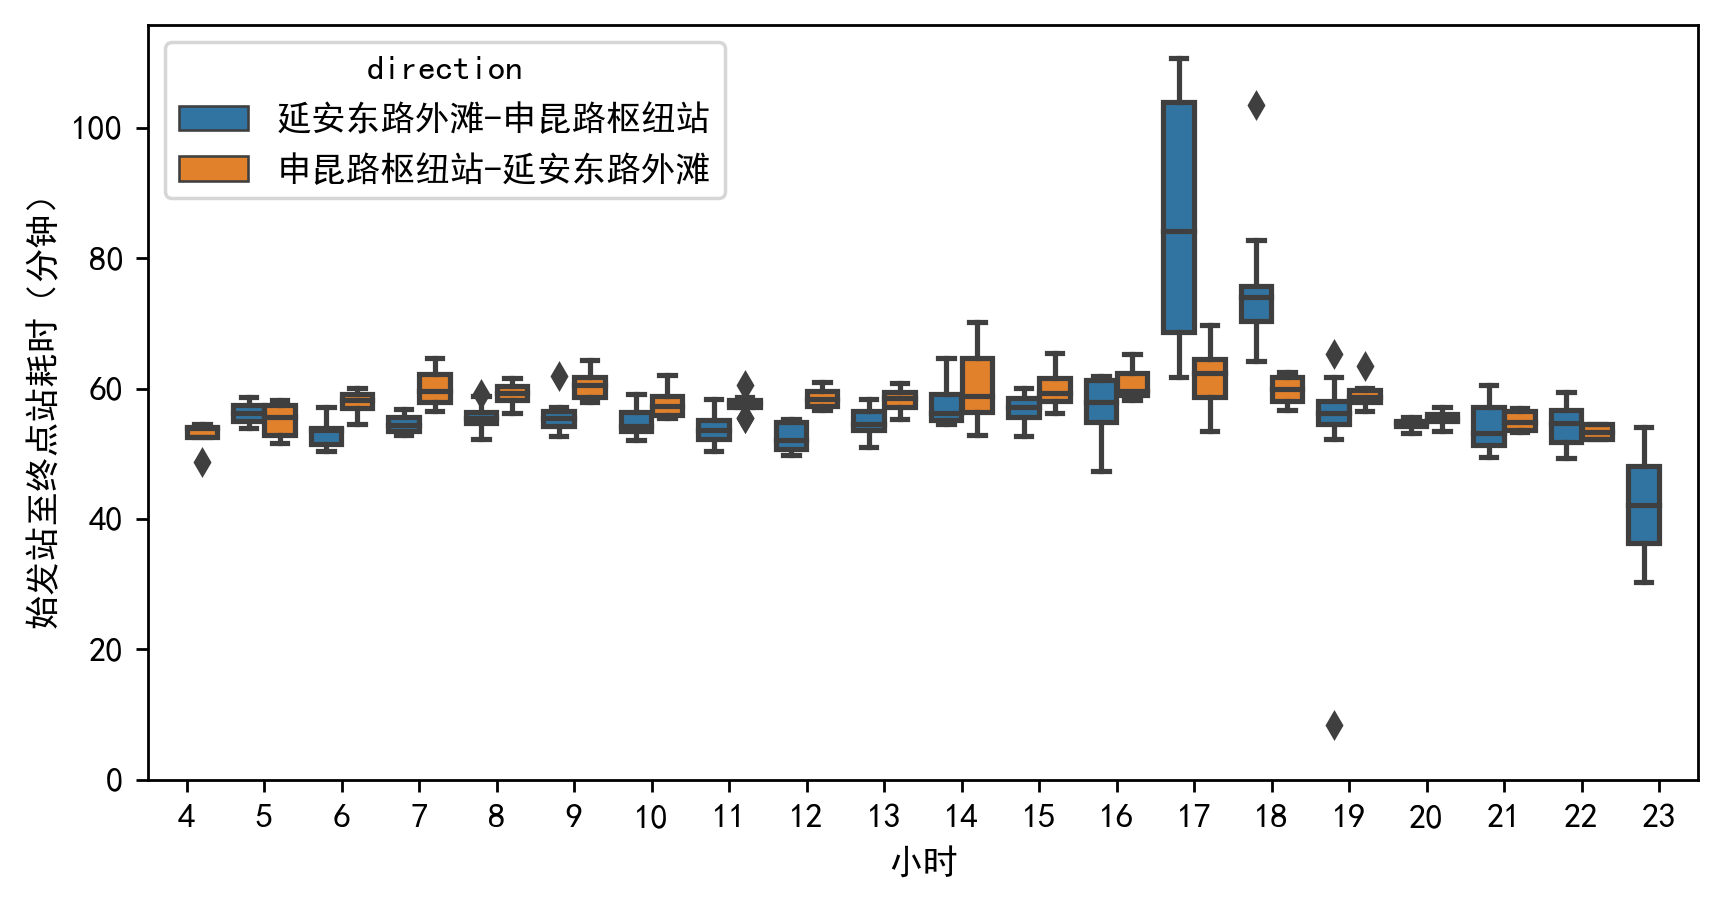

In [55]:
## 绘制耗时分布箱型图
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)

sns.boxplot(x = 'shour',y = onewaytime['duration']/60,
            hue = 'direction',data = onewaytime)

plt.ylabel('始发站至终点站耗时（分钟）')
plt.xlabel('小时')
plt.ylim(0)
plt.show()


## 运营速度

In [56]:
#公交线的长度
lineshp.length

17512.98594955427

In [57]:
#筛选去掉车速过快的
#车速单位转换为km/h
onewaytime['speed'] = (lineshp.length/onewaytime['duration'])*3.6
onewaytime = onewaytime[onewaytime['speed']<=60]

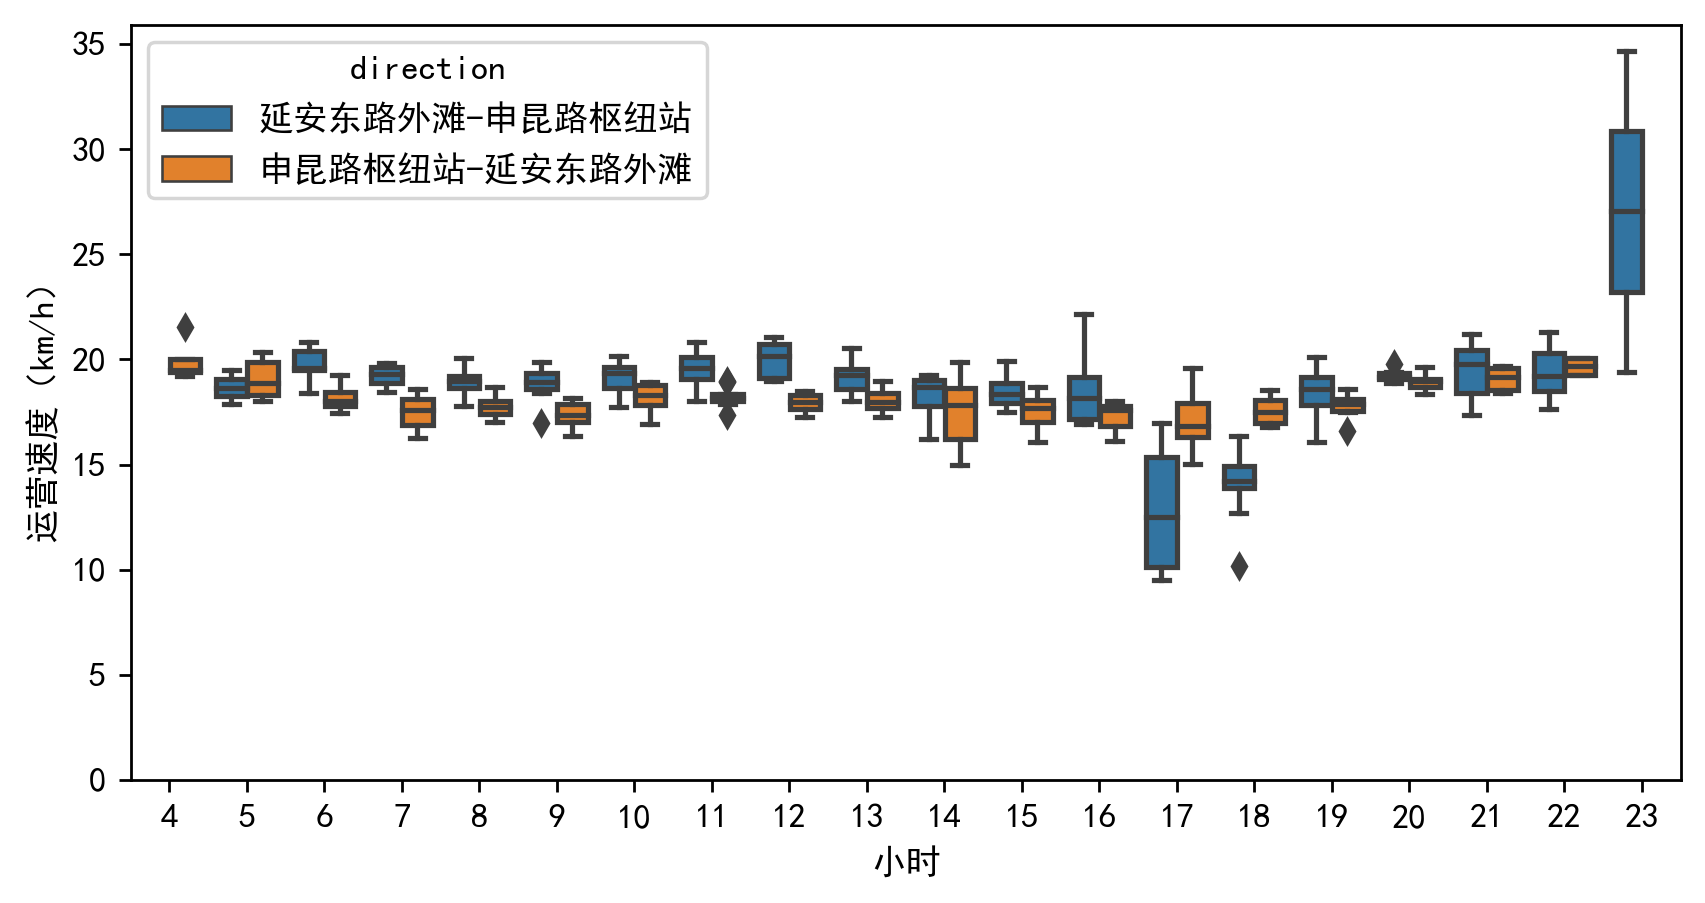

In [59]:
## 车速分布
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)
sns.boxplot(x = 'shour',y = 'speed',hue = 'direction',data = onewaytime)
plt.ylabel('运营速度（km/h）')
plt.xlabel('小时')
plt.ylim(0)
plt.show()

## 到站时间间隔计算

In [60]:
#到站时间间隔需要区分上行、下行，因此在这里要识别上行下行，为每个站点标上所在位置
arrive_info = pd.merge(arrive_info.sort_values(by = ['VehicleId','arrivetime']),
                       stop[['stopname','project']],on ='stopname')

In [61]:
#排序
arrive_info = arrive_info.sort_values(by = ['VehicleId','arrivetime'])
arrive_info['VehicleId1'] = arrive_info['VehicleId'].shift() 
arrive_info['project1'] = arrive_info['project'].shift()
tmp = arrive_info[arrive_info['VehicleId1'] == arrive_info['VehicleId']]
#通过对比起终点位置判断上行还是下行
tmp['ToDir'] = (tmp['project1']>tmp['project']).astype(int)

In [62]:
#对上行计算各站点的到站时间间隔  
tmp1 = tmp[tmp['ToDir']==1].sort_values(by = ['stopname','arrivetime'])  
tmp1['arrivetime1'] = tmp1['arrivetime'].shift(-1)  
tmp1['stopname1'] = tmp1['stopname'].shift(-1)  
tmp1 = tmp1[tmp1['stopname1'] == tmp1['stopname']]  
#计算到站时间间隔  
tmp1['duration'] = tmp1['arrivetime1'] - tmp1['arrivetime']  
#标记数据所在时间  
tmp1['shour'] = (tmp1['arrivetime']/3600).astype('int')  
#分别区分早晚高峰平峰数据  
tmp1.loc[(tmp1['shour'] == 7)|  
         (tmp1['shour'] == 8)|  
         (tmp1['shour'] == 9),'hue'] = '早高峰'  
tmp1.loc[(tmp1['shour'] == 18)|  
         (tmp1['shour'] == 19),'hue'] = '晚高峰'  
tmp1.loc[-((tmp1['shour'] == 7)|  
           (tmp1['shour'] == 8)|  
           (tmp1['shour'] == 9)|  
           (tmp1['shour'] == 18)|  
           (tmp1['shour'] == 19)),'hue'] = '平峰'  


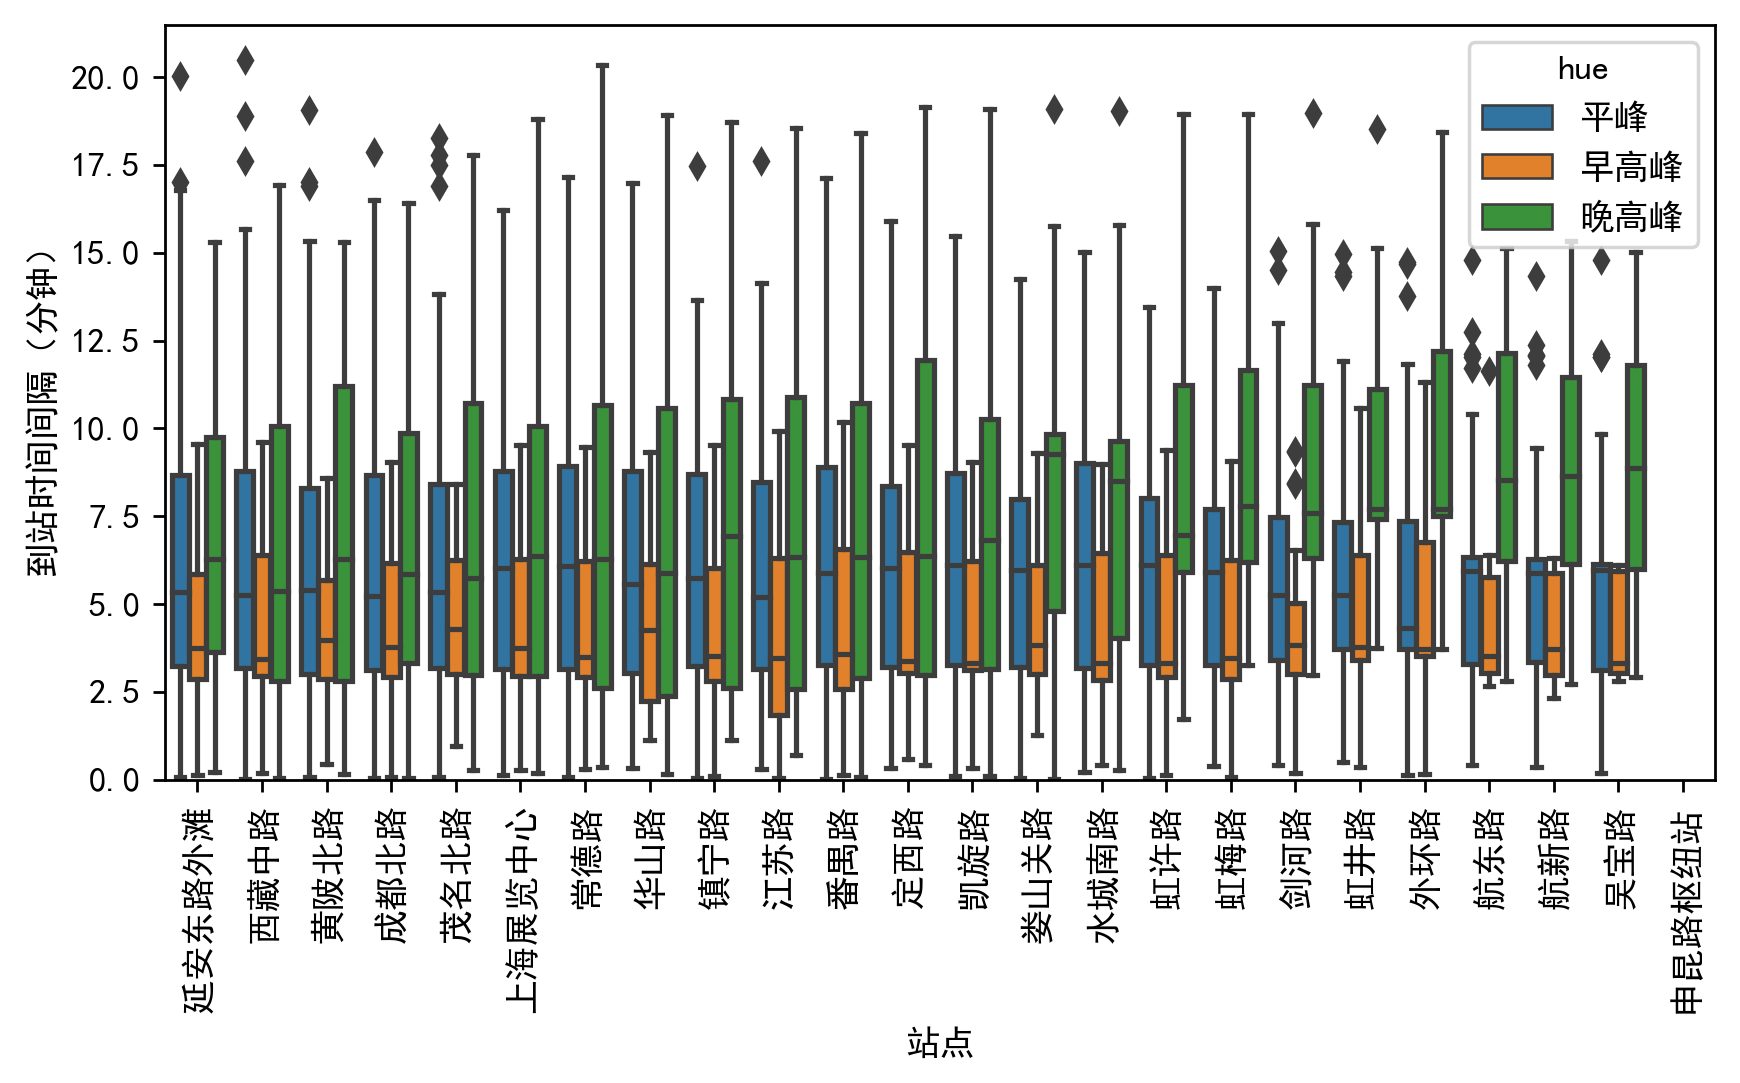

In [64]:
#下行的到站时间间隔绘制  
import matplotlib.pyplot as plt  
import seaborn as sns  
fig     = plt.figure(1,(8,4),dpi = 250)      
ax1      = plt.subplot(111)  
sns.boxplot(x='stopname',  
            y=tmp1['duration']/60,  
            data = tmp1,  
            hue = 'hue',  
            order = stop['stopname'])#设定x轴方向站点的排列顺序  
plt.ylabel('到站时间间隔（分钟）')  
plt.xlabel('站点')  
plt.ylim(0)  
plt.xticks(rotation = 90)  
plt.show()  
